In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import joblib
import shap
import matplotlib.pyplot as plt
import sys
import re

from pathlib import Path
from IPython.display import display

In [2]:
class MLP(nn.Module):
    def __init__(self, in_dim: int, p_drop: float = 0.5):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(p_drop),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32), nn.ReLU(), nn.Dropout(p_drop),
            nn.Linear(32, 64),
            nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(p_drop),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

In [3]:
def shap_analysis(model_path, preprocessor_path, x_test_path=None, y_test_path=None, x_train_path=None, y_train_path=None, input_dim_manual=None):
    FIG_SIZE = (10, 10)                  # matplotlib 그래프 크기 지정
    N_BG_PER_CLASS = 150                 # 클래스별 배경 샘플 개수
    BG_THRESHOLD   = 2 * N_BG_PER_CLASS  # 배경 샘플 부족 시 재추출 기준
    N_EXP_PER_CLASS = 2000               # 클래스별 설명 샘플 개수

    # Jupyter Notebook 출력 설정
    %config InlineBackend.print_figure_kwargs={'bbox_inches':None}
    %config InlineBackend.figure_format = 'png'

    # matplotlib 해상도 설정
    plt.rcParams['figure.dpi']  = 100
    plt.rcParams['savefig.dpi'] = 100

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    INPUT_DIM = 0                   # 모델 입력 벡터 차원
    feature_names_transformed = []  # 전처리/변환 후 특성 이름을 보관할 리스트

    try:
        loaded_pipe = joblib.load(preprocessor_path)                                        # 전처리 파이프라인 로드
        feature_names_transformed = loaded_pipe.named_steps['pre'].get_feature_names_out()  # 변환 후 특성 이름 추출
        INPUT_DIM = len(feature_names_transformed)                                          # 입력 차원 계산
        print(f"Input dimension from preprocessor: {INPUT_DIM}")
        print(f"Transformed feature names count from preprocessor: {len(feature_names_transformed)}")

    except FileNotFoundError:
        error_message = f"Error: Preprocessor file not found at {preprocessor_path}."
        print(error_message)

    except Exception as e:
        error_message = f"Error loading preprocessor or getting feature names: {e}."
        print(error_message)

    # 입력 차원 결정
    if input_dim_manual is not None:
        # 실행 전 명시적으로 지정한 값을 우선 사용
        INPUT_DIM = input_dim_manual
        print(f"Using manually specified INPUT_DIM: {INPUT_DIM}")

        # 전처리 파이프라인 부재로 인해 특성 이름을 모를 경우,임의로 특성 이름 생성
        if not feature_names_transformed:
             feature_names_transformed = [f"feature_{i}" for i in range(INPUT_DIM)]
             print("Warning: Using generic feature names as preprocessor was not loaded.")

    # 전처리 파이프라인으로부터 유효한 입력 차원을 확보한 경우
    elif INPUT_DIM > 0:
        pass

    # X_test.npy 파일에서 특성 이름 추정
    elif x_test_path:
        try:
            temp_x_data = np.load(x_test_path)
            INPUT_DIM = temp_x_data.shape[1]

            # 전처리 파이프라인 부재로 인해 특성 이름을 모를 경우,임의로 특성 이름 생성
            if not feature_names_transformed:
                feature_names_transformed = [f"feature_{i}" for i in range(INPUT_DIM)]

            print(f"Warning: INPUT_DIM ({INPUT_DIM}) and feature names inferred from X_test data due to preprocessor load issue.")

        except FileNotFoundError:
            error_message = f"Error: X_test file not found at {x_test_path} for INPUT_DIM inference. SHAP analysis aborted."
            print(error_message)
            sys.exit(error_message)

        except Exception as e:
            error_message = f"Error loading X_test data for INPUT_DIM inference: {e}. SHAP analysis aborted."
            print(error_message)
            sys.exit(error_message)

    # X_train(.npy) 파일에서 특성 이름 추정
    elif x_train_path:
        try:
            temp_x_data = np.load(x_train_path)
            INPUT_DIM = temp_x_data.shape[1]

            # 전처리 파이프라인 부재로 인해 특성 이름을 모를 경우,임의로 특성 이름 생성
            if not feature_names_transformed:
                feature_names_transformed = [f"feature_{i}" for i in range(INPUT_DIM)]

            print(f"Warning: INPUT_DIM ({INPUT_DIM}) and feature names inferred from X_train data due to preprocessor load issue.")

        except FileNotFoundError:
            error_message = f"Error: X_train file not found at {x_train_path} for INPUT_DIM inference. SHAP analysis aborted."
            print(error_message)
            sys.exit(error_message)

        except Exception as e:
            error_message = f"Error loading X_train data for INPUT_DIM inference: {e}. SHAP analysis aborted."
            print(error_message)
            sys.exit(error_message)

    else:
        error_message = "Error: Could not determine INPUT_DIM. Provide input_dim_manual or valid preprocessor/data paths. SHAP analysis aborted."
        print(error_message)
        sys.exit(error_message)

    # 입력 차원 유효성 검사
    if INPUT_DIM == 0:
        error_message = "Error: INPUT_DIM is 0. Cannot proceed with model initialization. SHAP analysis aborted."
        print(error_message)
        sys.exit(error_message)

    # MLP 모델 객체 생성
    model = MLP(INPUT_DIM).to(device)

    # 가중치 로드
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))

    except FileNotFoundError:
        error_message = f"Error: Model file not found at {model_path}. SHAP analysis aborted."
        print(error_message)
        sys.exit(error_message)

    except RuntimeError as e:
        error_message = f"Error loading model state_dict (check INPUT_DIM and model structure): {e}. SHAP analysis aborted."
        print(error_message)
        sys.exit(error_message)

    except Exception as e:
        error_message = f"Error loading model: {e}. SHAP analysis aborted."
        print(error_message)
        sys.exit(error_message)

    model.eval()
    print("Model loaded successfully.")

    # SHAP 배경 데이터 추출
    if x_train_path:
        try:
            # X_train_processed: 전처리가 완료된 행렬 (N, INPUT_DIM)
            X_train_processed = np.load(x_train_path)

            # 특성 수 일치 여부 검증
            if X_train_processed.shape[1] != INPUT_DIM:
                error_message = f"Error: Background data feature dimension ({X_train_processed.shape[1]}) mismatch with INPUT_DIM ({INPUT_DIM}). SHAP analysis aborted."
                print(error_message)
                sys.exit(error_message)

            # 서브 샘플링
            if X_train_processed.shape[0] > BG_THRESHOLD:                       # shape[0]: 학습 샘플 총 개수 N
                try:
                    # 클래스 균형 유지
                    y_train = np.load(y_train_path)                             # 라벨 로드

                    idx_pos = np.where(y_train == 1)[0]                         # 양성 클래스
                    idx_neg = np.where(y_train == 0)[0]                         # 음성 클래스

                    n = min(BG_THRESHOLD, len(idx_pos), len(idx_neg))           # BG_THRESHOLD를 넘지 않으며 가장 적은 클래스 개수에 맞춰 균형 보장

                    sel_pos = np.random.choice(idx_pos, n, replace=False)       # 양성 클래스에서 중복 없이 무작위 선택
                    sel_neg = np.random.choice(idx_neg, n, replace=False)       # 음성 클래스에서 중복 없이 무작위 선택

                    background_indices = np.r_[sel_pos, sel_neg]                # 클래스 인덱스 결합
                    background_data_np = X_train_processed[background_indices]  # 최종 배경 데이터 추출

                except Exception:
                    indices_background = np.random.choice(X_train_processed.shape[0], BG_THRESHOLD, replace=False)
                    background_data_np = X_train_processed[indices_background]

            # 학습 샘플 개수가 BG_THRESHOLD 이하인 경우 그대로 처리
            else:
                background_data_np = X_train_processed

            # NumPy 배열에서 Tensor로 변환
            background_data_tensor = torch.from_numpy(background_data_np).float().to(device)
            print(f"Background data loaded from {x_train_path}, shape: {background_data_tensor.shape}")

        except FileNotFoundError:
            error_message = f"Error: X_train processed file not found at {x_train_path}. Cannot create background data. SHAP analysis aborted."
            print(error_message)
            sys.exit(error_message)

    else:
        print(f"Warning: x_train_path not provided. Generating random background data. This might affect SHAP results.")
        background_data_np = np.random.rand(BG_THRESHOLD, INPUT_DIM).astype(np.float32)
        background_data_tensor = torch.from_numpy(background_data_np).float().to(device)

    # SHAP 설명 대상 데이터 추출
    if x_test_path:
        try:
            X_test_processed = np.load(x_test_path)

            if X_test_processed.shape[1] != INPUT_DIM:
                error_message = f"Error: Data to explain feature dimension ({X_test_processed.shape[1]}) mismatch with INPUT_DIM ({INPUT_DIM}). SHAP analysis aborted."
                print(error_message)
                sys.exit(error_message)

            if X_test_processed.shape[0] > 2 * N_EXP_PER_CLASS:
                try:
                    y_test = np.load(y_test_path)

                    idx_pos_all = np.where(y_test == 1)[0]
                    idx_neg_all = np.where(y_test == 0)[0]

                    n_pos = min(N_EXP_PER_CLASS, len(idx_pos_all))
                    n_neg = min(N_EXP_PER_CLASS, len(idx_neg_all))

                    idx_pos = rng.choice(idx_pos_all, size=n_pos, replace=False)
                    idx_neg = rng.choice(idx_neg_all, size=n_neg, replace=False)

                    idx_combined = np.r_[idx_pos, idx_neg]
                    rng.shuffle(idx_combined)

                    data_to_explain_np = X_test_processed[idx_combined]

                except Exception:
                    data_to_explain_np = X_test_processed[:2 * N_EXP_PER_CLASS]

            else:
                data_to_explain_np = X_test_processed

            data_to_explain_tensor = torch.from_numpy(data_to_explain_np).float().to(device)
            print(f"Data to explain loaded from {x_test_path}, shape: {data_to_explain_tensor.shape}")

        except FileNotFoundError:
            error_message = f"Error: X_test processed file not found at {x_test_path}. Cannot get data to explain. SHAP analysis aborted."
            print(error_message)
            sys.exit(error_message)

    else:
        print(f"Warning: x_test_path not provided. Generating random data.")
        data_to_explain_np = np.random.rand(2 * N_EXP_PER_CLASS, INPUT_DIM).astype(np.float32)
        data_to_explain_tensor = torch.from_numpy(data_to_explain_np).float().to(device)

    """
    배경 데이터: background_data_tensor
    설명 대상 데이터: data_to_explain_tensor
    """

    explainer = shap.DeepExplainer(model, background_data_tensor)       # MLP 모델과 배경 데이터를 SHAP 계산 엔진에 저장
    shap_values_tensor = explainer.shap_values(data_to_explain_tensor)  # 설명 대상 데이터와 배경 데이터를 조합하여 Shapley 값 계산 → 각 특성 기여도 반환

    # 반환값이 리스트인 경우
    if isinstance(shap_values_tensor, list):
        shap_values_np_list = []

        for s_tensor_or_array in shap_values_tensor:
            temp_array = s_tensor_or_array

            if hasattr(temp_array, 'is_cuda') and temp_array.is_cuda:
                temp_array = temp_array.cpu()                   # CPU로 연산

            if hasattr(temp_array, 'numpy'):
                shap_values_np_list.append(temp_array.numpy())  # NumPy 배열로 변환

            elif isinstance(temp_array, np.ndarray):
                shap_values_np_list.append(temp_array)

            else:
                shap_values_np_list.append(np.array(temp_array))

        shap_values_for_plot = shap_values_np_list[1]  # shap_values_for_plot[i, j]: i번째 샘플이 클래스 0(양성) 관점에서 모델에 들어갔을 때, j번째 특성이 얼마나 모델 출력에 기여했는가?
        ev = explainer.expected_value                  # 배경 데이터를 모델에 넣었을 때 나온 예측값을 평균 낸 결과

        # (특성 개수 X 샘플 개수) 형태 여부 확인 후 전치
        if shap_values_for_plot.shape[0] == INPUT_DIM and shap_values_for_plot.shape[1] != INPUT_DIM:
            shap_values_for_plot = shap_values_for_plot.T
            print(f"[Info] shap_values_for_plot transposed to {shap_values_for_plot.shape}")

        if hasattr(ev, 'is_cuda') and ev.is_cuda:
             expected_value_for_plot = ev.cpu().numpy()         # CPU로 이동 후 NumPy 배열로 변환

        elif hasattr(ev, 'numpy'):
             expected_value_for_plot = ev.numpy()               # NumPy 배열로 변환

        else:
             expected_value_for_plot = np.array(ev)

    # 반환값이 단일 Tensor 또는 NumPy 배열인 경우
    elif hasattr(shap_values_tensor, 'is_cuda') and shap_values_tensor.is_cuda:
        shap_values_np = shap_values_tensor.cpu().numpy()
        shap_values_for_plot = shap_values_np
        ev = explainer.expected_value

        if hasattr(ev, 'is_cuda') and ev.is_cuda:
             expected_value_for_plot = ev.cpu().numpy()

        elif hasattr(ev, 'numpy'):
             expected_value_for_plot = ev.numpy()

        else:
             expected_value_for_plot = np.array(ev)

    elif hasattr(shap_values_tensor, 'numpy'):
        shap_values_np = shap_values_tensor.numpy()
        shap_values_for_plot = shap_values_np
        ev = explainer.expected_value

        if hasattr(ev, 'is_cuda') and ev.is_cuda:
             expected_value_for_plot = ev.cpu().numpy()

        elif hasattr(ev, 'numpy'):
             expected_value_for_plot = ev.numpy()

        else:
             expected_value_for_plot = np.array(ev)

    elif isinstance(shap_values_tensor, np.ndarray):
        shap_values_np = shap_values_tensor
        shap_values_for_plot = shap_values_np
        ev = explainer.expected_value

        if hasattr(ev, 'is_cuda') and ev.is_cuda:
             expected_value_for_plot = ev.cpu().numpy()

        elif hasattr(ev, 'numpy'):
             expected_value_for_plot = ev.numpy()

        else:
             expected_value_for_plot = np.array(ev)

    # 반환값이 그 외 모든 경우
    else:
        error_message = f"Unexpected type for shap_values_tensor: {type(shap_values_tensor)}. SHAP analysis might fail."
        print(error_message)

        try:
            shap_values_np = np.array(shap_values_tensor)
            shap_values_for_plot = shap_values_np
            ev = explainer.expected_value

            if hasattr(ev, 'is_cuda') and ev.is_cuda:
                 expected_value_for_plot = ev.cpu().numpy()

            elif hasattr(ev, 'numpy'):
                 expected_value_for_plot = ev.numpy()

            else:
                 expected_value_for_plot = np.array(ev)

        except Exception as e:
            final_error_message = f"Failed to convert shap_values_tensor to NumPy array: {e}. SHAP analysis aborted."
            print(final_error_message)
            sys.exit(final_error_message)

    # 차원 정리
    if shap_values_for_plot.ndim == 3 and shap_values_for_plot.shape[-1] == 1:
        shap_values_for_plot = shap_values_for_plot.squeeze(-1)                 # (N,F,1) → (N,F)

    if shap_values_for_plot.ndim == 1:
        shap_values_for_plot = shap_values_for_plot.reshape(-1, 1)              # (N,) → (N,1)

    if shap_values_for_plot.shape != data_to_explain_np.shape:                  # 차원 불일치 시 전치
        if shap_values_for_plot.T.shape == data_to_explain_np.shape:
            shap_values_for_plot = shap_values_for_plot.T
            print(f"[Info] transposed SHAP matrix ➜ {shap_values_for_plot.shape}")

        else:
            raise ValueError(
                f"shap_values_for_plot shape {shap_values_for_plot.shape} ≠ data_to_explain_np shape {data_to_explain_np.shape}\n"
                "→ The two arrays must have the same (samples, features) shape for dependence_plot to work."
            )

    # 배경 데이터를 모델에 입력해서 얻은 평균 예측값
    current_expected_value = expected_value_for_plot

    # current_expected_value가 NumPy 배열인 경우
    if isinstance(current_expected_value, np.ndarray):
        # 배열 내부에 값이 하나만 있는 상황
        if current_expected_value.size == 1:
            base_value = current_expected_value.item()

        # 배열이 1차원 이상이며 요소가 하나 이상 존재하는 경우
        elif current_expected_value.ndim > 0 and current_expected_value.shape[0] > 0 :
            first_element = current_expected_value[1]  # 클래스 0(양성) 관점에서 배경 데이터의 평균 예측값 → base_value

            if isinstance(first_element, np.ndarray) and first_element.size == 1:
                 base_value = first_element.item()

            elif isinstance(first_element, (float, int, np.number)):
                 base_value = float(first_element)

            else:
                 base_value = float(first_element)

            print(f"Warning: expected_value_for_plot had multiple values ({current_expected_value}). Using the first one after scalar conversion: {base_value}")

        else:
             base_value = current_expected_value.item()

    elif isinstance(current_expected_value, (float, int, np.number)):
        base_value = float(current_expected_value)

    else:
        print(f"Warning: Unexpected type for expected_value_for_plot: {type(current_expected_value)}. Attempting to convert to float.")

        try:
            base_value = float(current_expected_value)

        except (ValueError, TypeError) as e_conv:
            error_message = f"Critical Error: base_value (original type: {type(current_expected_value)}, value: {current_expected_value}) could not be converted to a Python scalar: {e_conv}. SHAP analysis aborted."
            print(error_message)
            sys.exit(error_message)

    # SHAP Force Plot
    # 설명 대상 데이터(data_to_explain_tensor)에 대한 예측 계산
    with torch.no_grad():
        raw_out = model(data_to_explain_tensor).cpu().numpy().ravel()

    model_probs   = 1 / (1 + np.exp(-raw_out))              # 시그모이드 함수 적용
    idx_high_risk = int(np.argmax(model_probs))             # 최대 양성 샘플의 인덱스
    idx_low_risk  = int(np.argmin(model_probs))             # 최대 음성 샘플의 인덱스

    for tag, row_idx in [("The highest-risk", idx_high_risk), ("The lowest-risk",  idx_low_risk)]:
        shap_values_single = shap_values_for_plot[row_idx]  # 해당 샘플이 클래스0(양성) 관점에서 각 특성이 예측에 기여한 값
        features_single    = data_to_explain_np[row_idx]    # 해당 샘플의 원본 특성 값

        print(f"\nSHAP Force Plot: {tag} sample, prob={model_probs[row_idx]:.3f}")

        fig = shap.force_plot(
            base_value,
            shap_values_single,
            features_single,
            feature_names=feature_names_transformed,
            matplotlib=True, show=False, text_rotation=10
        )
        fig.set_dpi(plt.rcParams['figure.dpi'])
        fig.set_size_inches(20, 5)
        ax = fig.axes[0]

        for t in list(ax.texts):
            txt = t.get_text().strip()

            if ' = ' in txt:
                t.set_fontsize(14)

            elif re.fullmatch(r"-?\d+(\.\d+)?", txt):
                t.set_fontsize(16)
                t.set_fontweight("bold")

        ax.set_title(f"Force Plot ({tag})")
        plt.tight_layout()
        plt.show()

    # SHAP Waterfall Plot
    print(f"\nSHAP Waterfall Plot")

    exp = shap.Explanation(
            values        = shap_values_single,
            base_values   = base_value,
            data          = features_single,
            feature_names = feature_names_transformed
    )

    fig, ax = plt.subplots(figsize=(10, 10))  # 빈 Figure와 Axis 생성
    plt.sca(ax)                               # 현재 ax 객체를 활성 축으로 지정
    ax = shap.plots.waterfall(                # 축을 활성화한 뒤 waterfall 호출
        exp,
        max_display=10,
        show=False
    )
    fig = ax.get_figure()
    fig.set_dpi(plt.rcParams['figure.dpi'])
    fig.set_size_inches(10, 10)
    plt.tight_layout()
    plt.show()

    # SHAP Summary Plot
    print("\nSHAP Summary Plot")

    if data_to_explain_np.shape[0] > 0:
        try:
            shap.summary_plot(shap_values_for_plot, data_to_explain_np, feature_names=feature_names_transformed, plot_size=FIG_SIZE, show=False)
            fig = plt.gcf()  # 활성화된 Figure 객체 반환
            fig.set_dpi(plt.rcParams['figure.dpi'])
            fig.set_size_inches(*FIG_SIZE)
            plt.tight_layout()
            plt.show()

        except Exception as e_summary:
            print(f"Error during SHAP summary_plot generation: {e_summary}")

    else:
        print("No data to display in summary plot.")

    # SHAP Dependence Plot for feature
    if data_to_explain_np.shape[1] > 0 :
        abs_mean = np.abs(shap_values_for_plot).mean(axis=0)
        top_idx   = np.argsort(abs_mean)[-5:][::-1]

        for i in top_idx:
            current_feature_name = feature_names_transformed[i]
            print(f"\nSHAP Dependence Plot for feature: {current_feature_name}")
            fig, ax = plt.subplots(figsize=FIG_SIZE)

            try:
                shap.dependence_plot(
                    i,
                    shap_values_for_plot,
                    data_to_explain_np,
                    feature_names=feature_names_transformed,
                    interaction_index="auto",
                    ax=ax,
                    show=False
                )
                fig.set_dpi(plt.rcParams['figure.dpi'])
                fig.set_size_inches(*FIG_SIZE)
                plt.tight_layout()
                plt.show()

            except Exception as e_dep:
                print(f"Error during SHAP dependence_plot for {current_feature_name}: {e_dep}")

    else:
        print("\nNo features available to generate SHAP Dependence Plot.")

Device: cuda
Input dimension from preprocessor: 13
Transformed feature names count from preprocessor: 13
Model loaded successfully.
Background data loaded from /content/drive/MyDrive/Colab Notebooks/Malicious URL Detection/data/x_train_processed.npy, shape: torch.Size([600, 13])
Data to explain loaded from /content/drive/MyDrive/Colab Notebooks/Malicious URL Detection/data/x_test_processed.npy, shape: torch.Size([4000, 13])

SHAP Force Plot: The highest-risk sample, prob=1.000


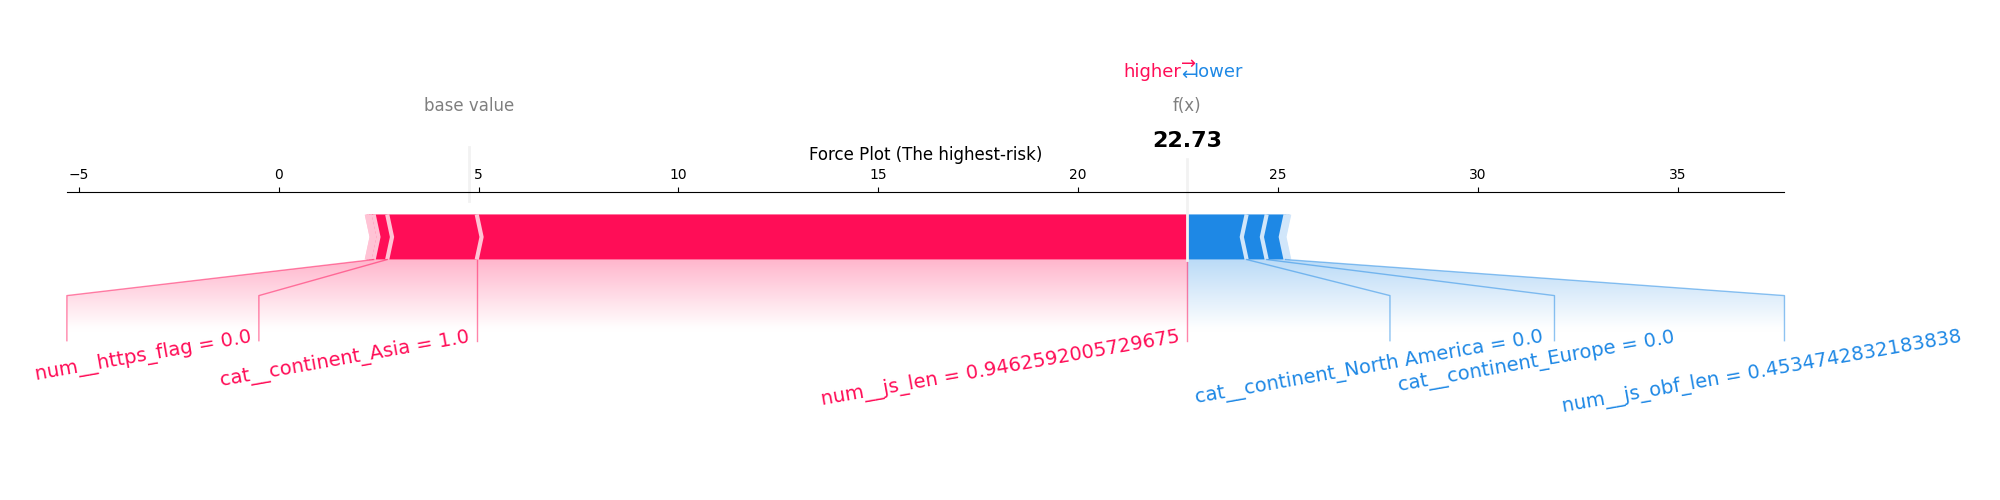


SHAP Force Plot: The lowest-risk sample, prob=0.001


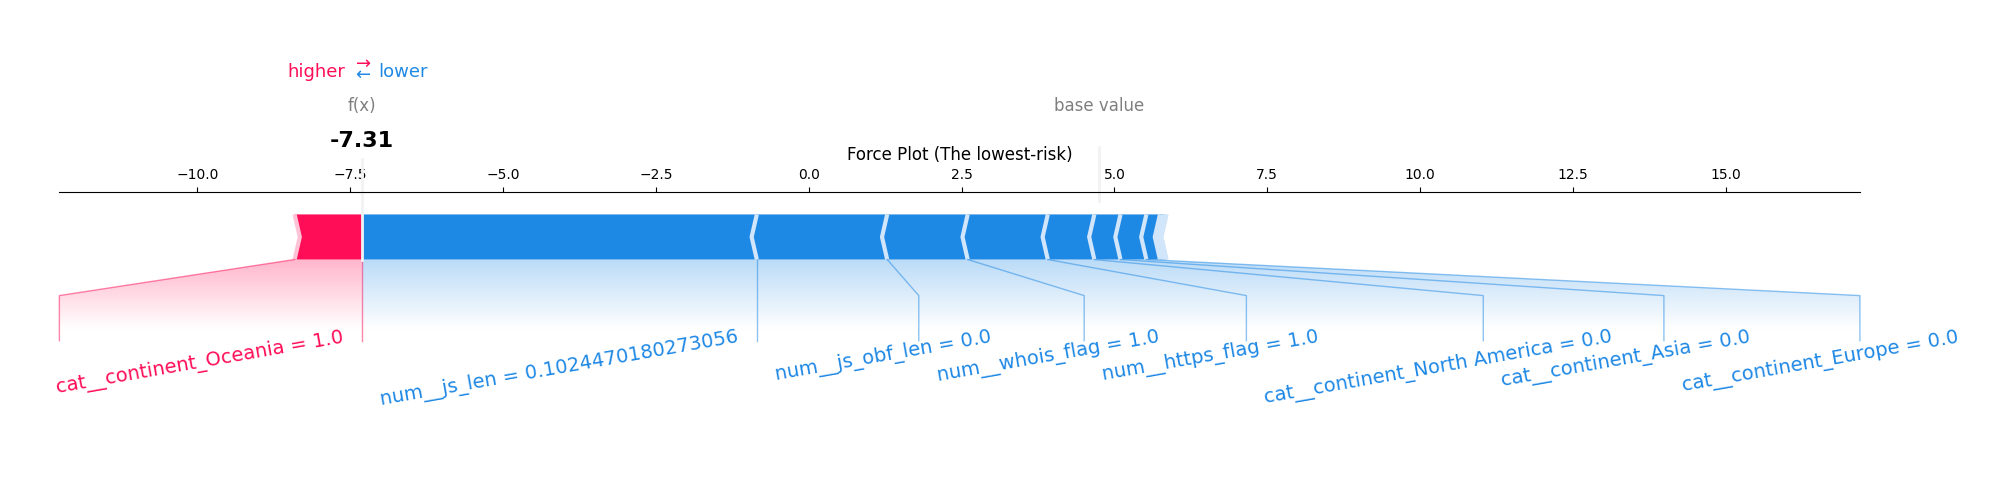


SHAP Waterfall Plot


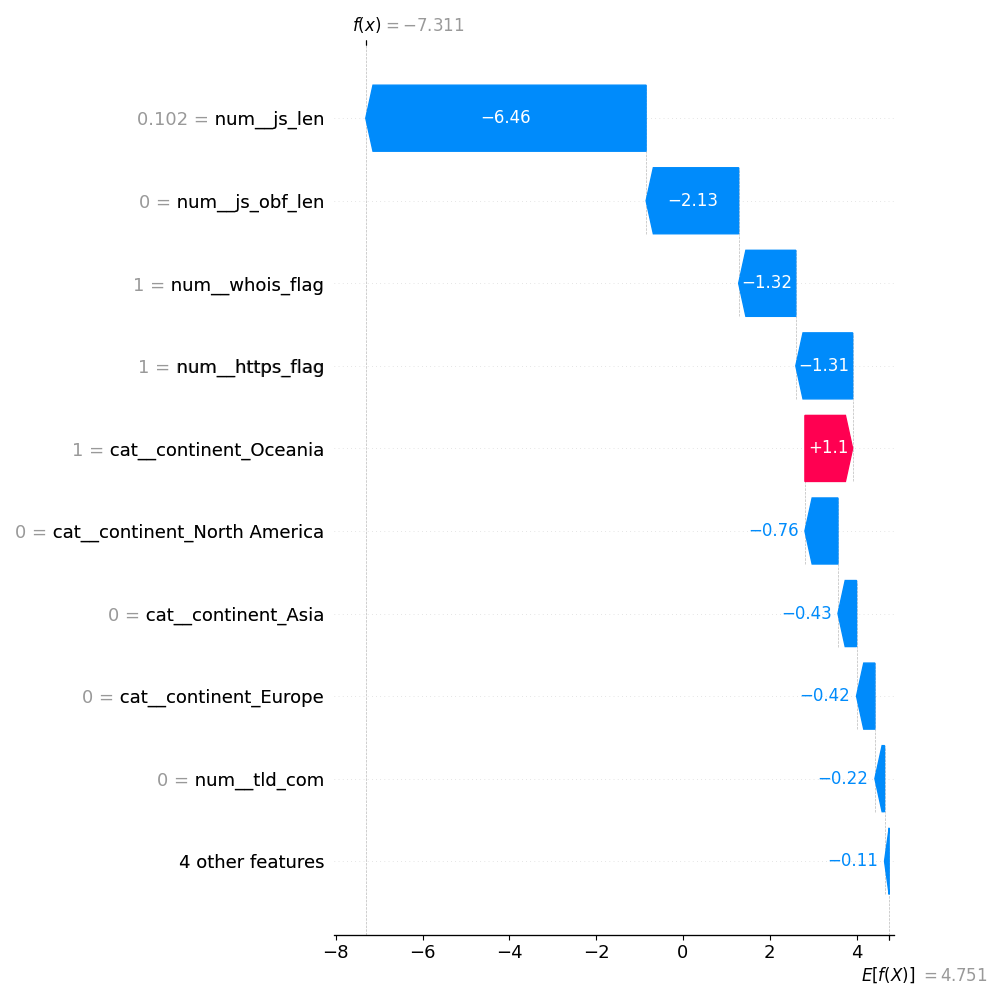


SHAP Summary Plot


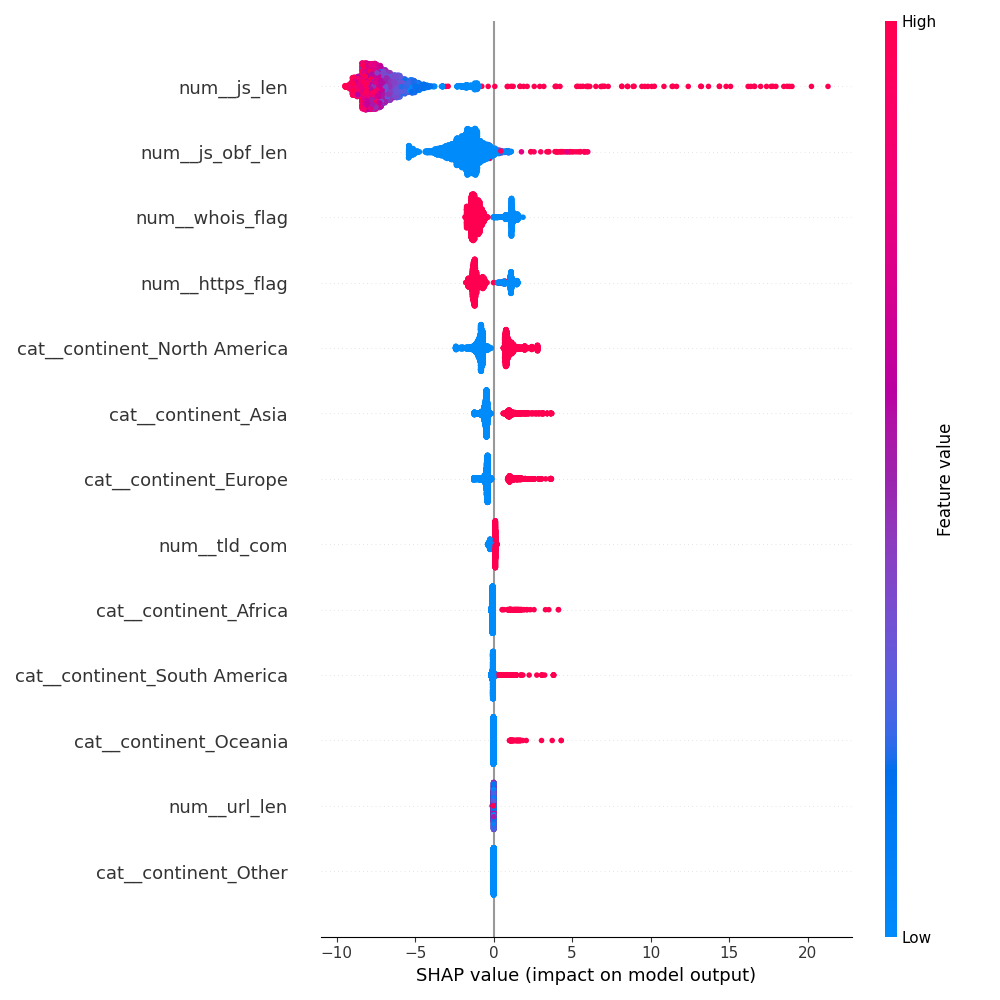


SHAP Dependence Plot for feature: num__js_len


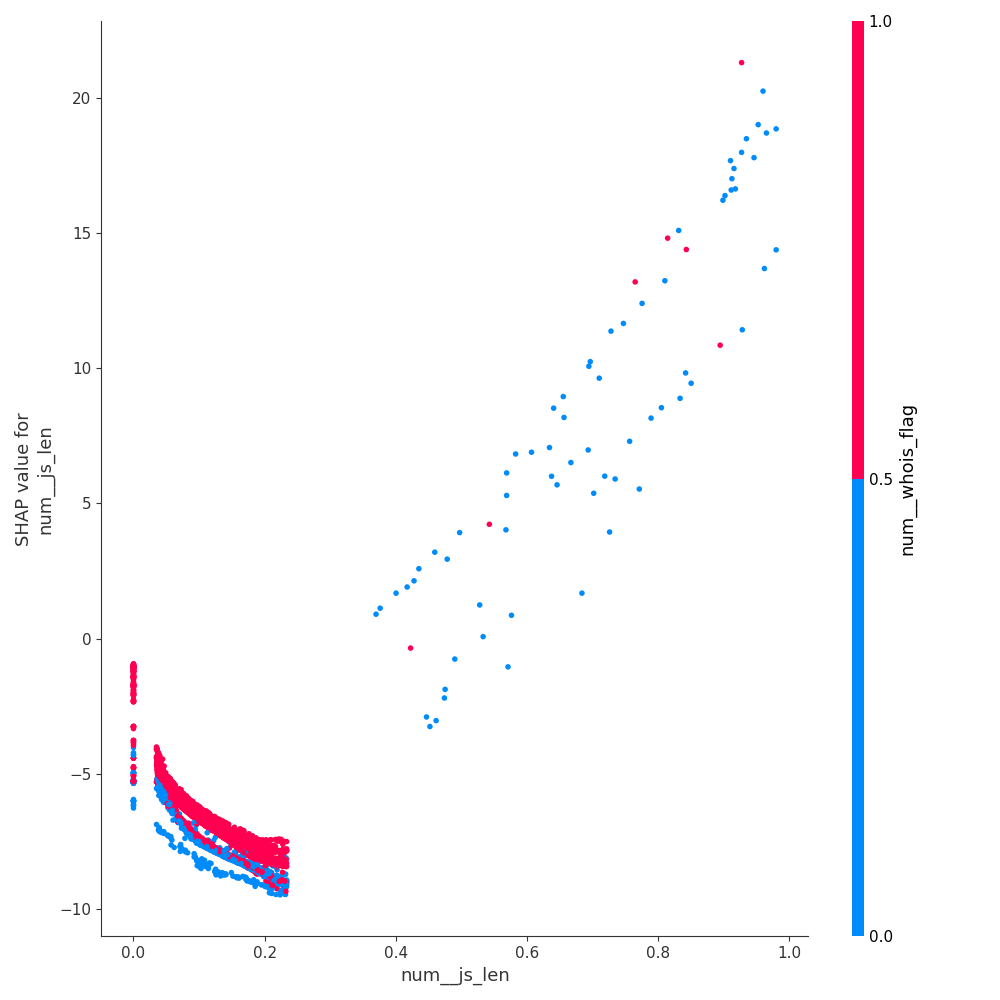


SHAP Dependence Plot for feature: num__js_obf_len


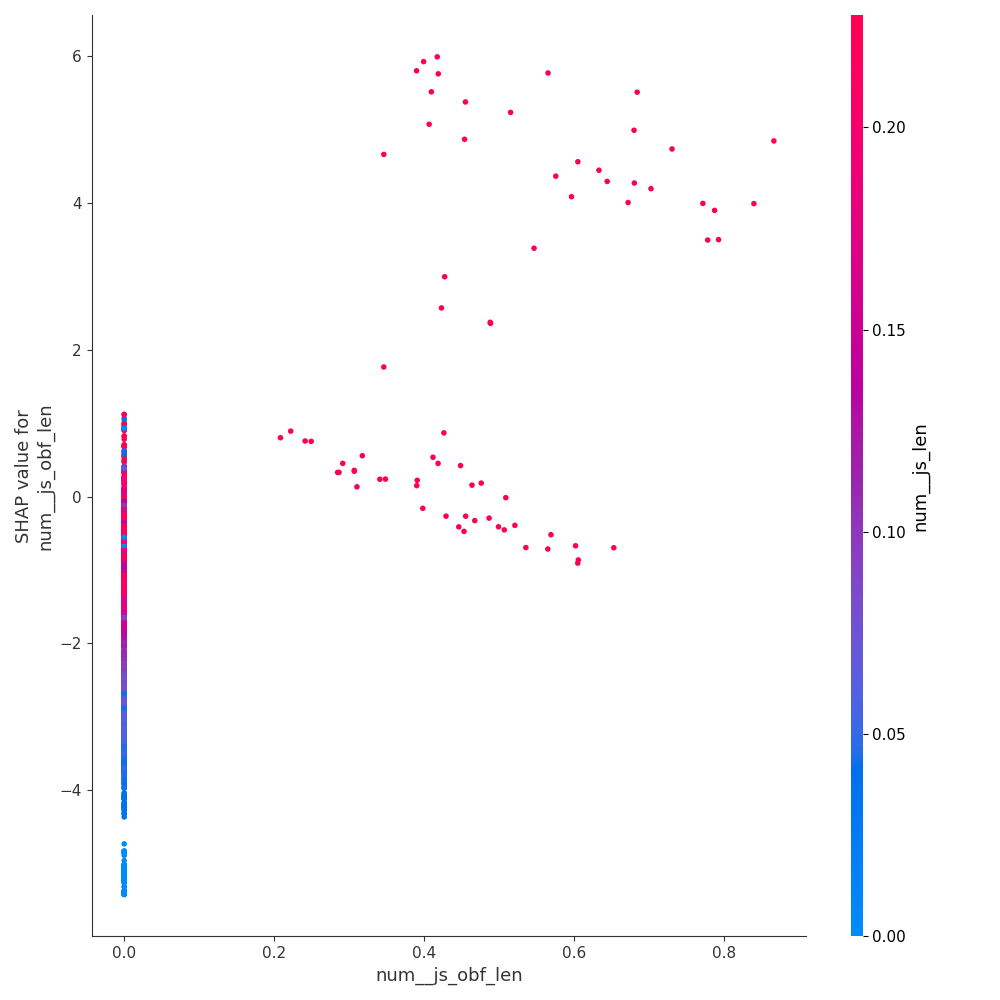


SHAP Dependence Plot for feature: num__whois_flag


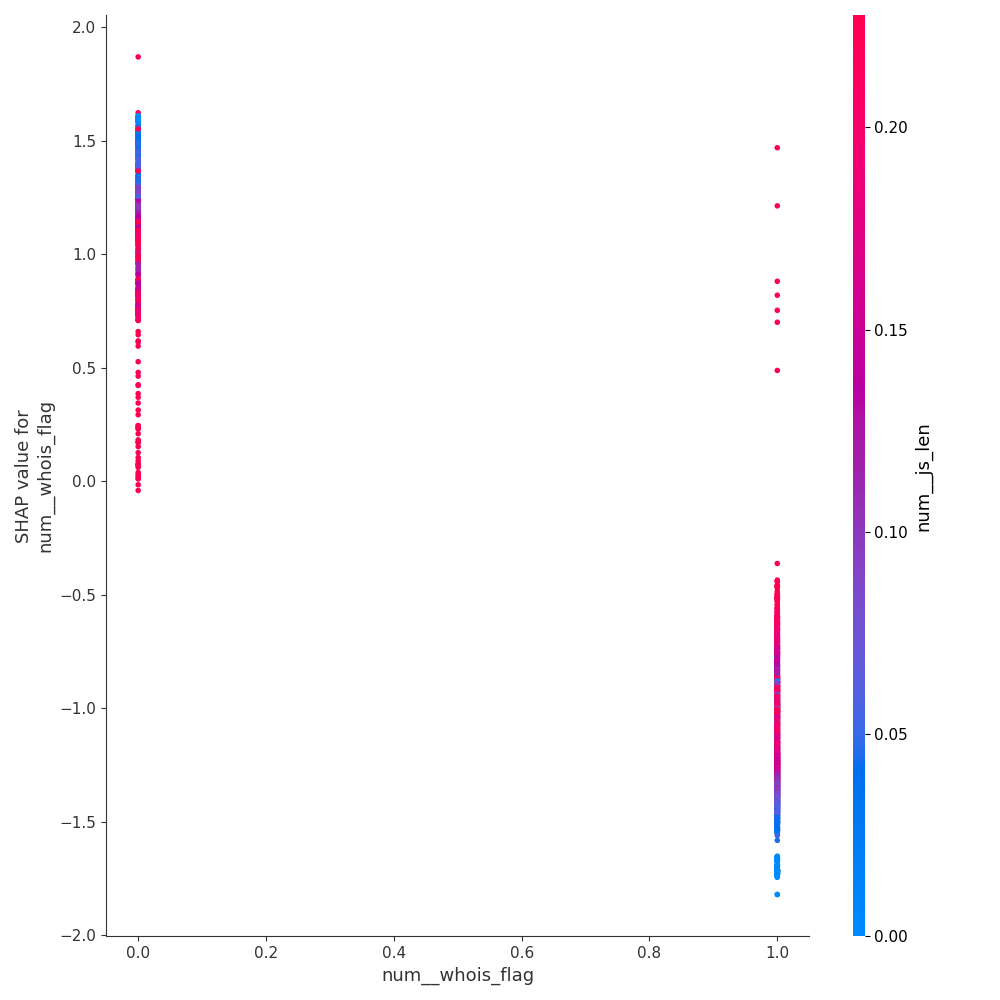


SHAP Dependence Plot for feature: num__https_flag


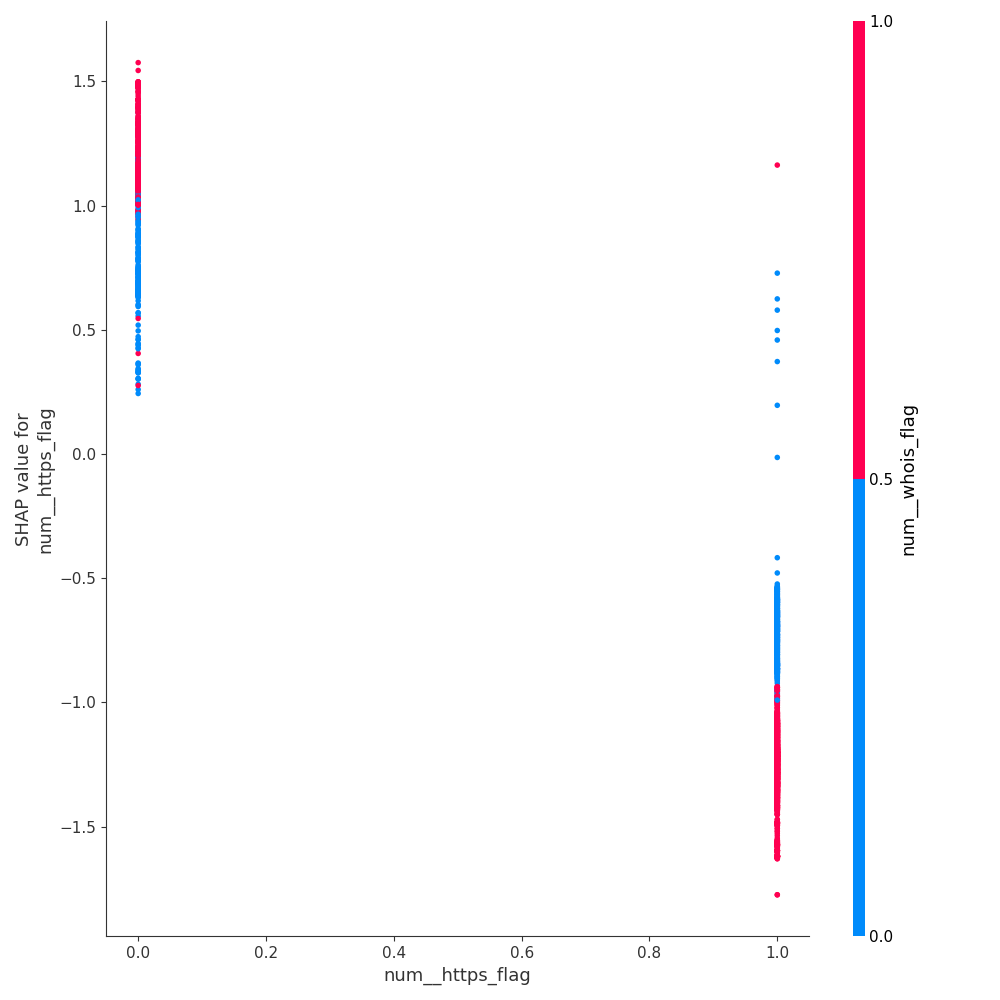


SHAP Dependence Plot for feature: cat__continent_North America


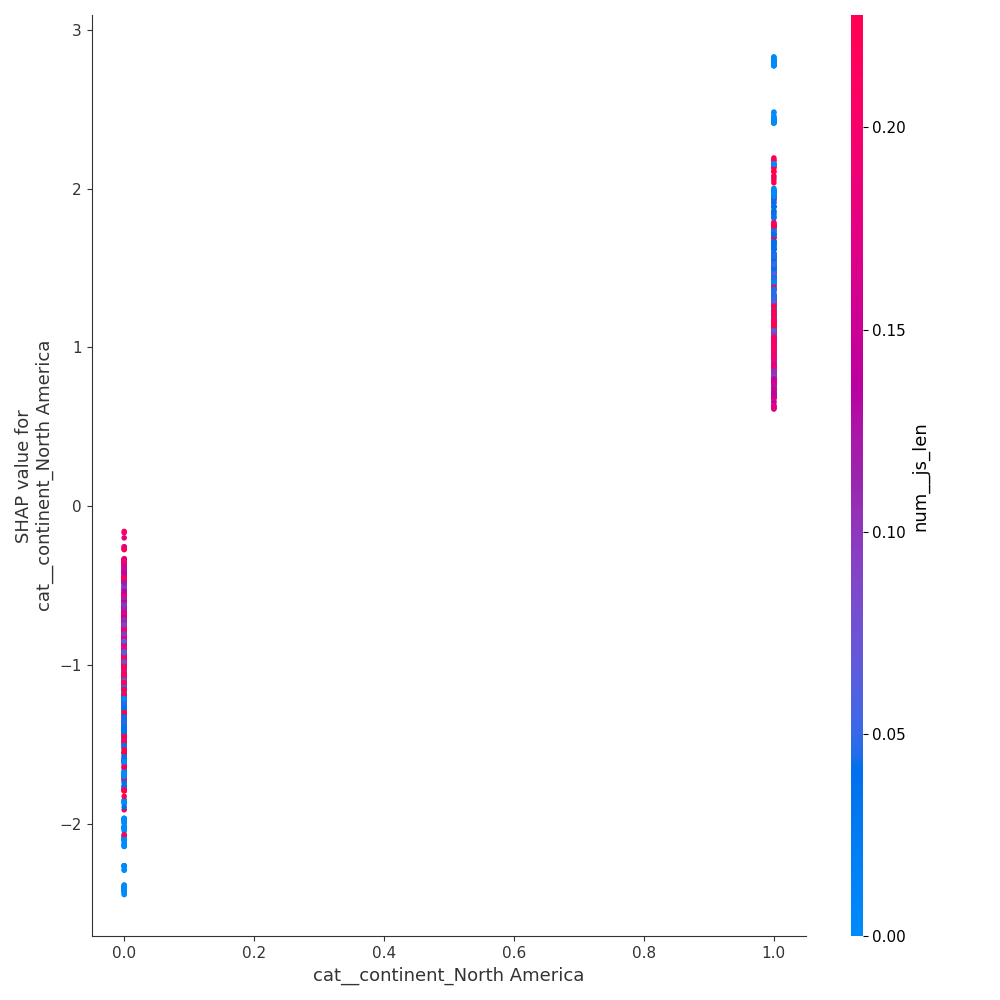

In [4]:
if __name__ == "__main__":
    DIRECTORY = Path("/content/drive/MyDrive/Colab Notebooks/Malicious URL Detection/data")
    MODEL_FILE_PATH        = DIRECTORY / "model.pt"
    PREPROCESSOR_FILE_PATH = DIRECTORY / "preprocess.joblib"
    X_TRAIN_PROCESSED_PATH = DIRECTORY / "x_train_processed.npy"
    X_TEST_PROCESSED_PATH  = DIRECTORY / "x_test_processed.npy"
    Y_TRAIN_PROCESSED_PATH = DIRECTORY / "y_train.npy"
    Y_TEST_PROCESSED_PATH  = DIRECTORY / "y_test.npy"

    INPUT_DIM_MANUAL = None

    shap_analysis(MODEL_FILE_PATH,
                  PREPROCESSOR_FILE_PATH,
                  x_test_path=X_TEST_PROCESSED_PATH,
                  y_test_path=Y_TEST_PROCESSED_PATH,
                  x_train_path=X_TRAIN_PROCESSED_PATH,
                  y_train_path=Y_TRAIN_PROCESSED_PATH,
                  input_dim_manual=INPUT_DIM_MANUAL)